$$\require{mhchem}$$

# Test case $\ce{LiFePO4}$

Use existence data of $\ce{LiFePO4}$ search and check if the low energy structures can be find by relaxation using M3GNet.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    

import warnings
from pathlib import Path
from ase.io import read
import ase
from m3gnet.models import Relaxer
from pymatgen.ext.matproj import MPRester

import pandas as pd

from tqdm import tqdm

from disp.analysis.airssutils import RESFile

from ase.io import read
from pymatgen.io.ase import AseAtomsAdaptor

2023-03-28 13:35:25.167059: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-28 13:35:25.228291: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


$$\require{mhchem}$$
Locate the $\ce{LiFePO4}$ structures from MP

Relax the experimental structures

In [2]:
lfp_mp = Structure.from_file("LiFePO4-mp-19017.vasp")

lfp_cmcm = Structure.from_file("LiFePO4-mp-18951.vasp")

In [3]:
relaxer = Relaxer()

results = relaxer.relax(lfp_mp)
lfp_relaxed = results['final_structure']
lfp_relaxed_energy = results['trajectory'].energies[-1] / len(lfp_relaxed.sites)
lfp_relaxed_volume = lfp_relaxed.volume / len(lfp_relaxed.sites)


results = relaxer.relax(lfp_cmcm)
lfp_cmcm_relaxed = results['final_structure']
lfp_cmcm_relaxed_energy = results['trajectory'].energies[-1] / len(lfp_cmcm_relaxed.sites)
lfp_cmcm_relaxed_volume = lfp_cmcm_relaxed.volume / len(lfp_cmcm_relaxed.sites)

2023-03-28 13:35:29.522128: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-03-28 13:35:29.522178: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (OdinComet): /proc/driver/nvidia/version does not exist
2023-03-28 13:35:29.522693: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
def load_dataset(names):
    """Load dataset"""
    cells = [read(x) for x in  tqdm(names)]
    for atoms, name in zip(cells, input_names):
        atoms.info['fname'] = name.stem

    dataset = []
    for atoms in cells:
        dataset.append(
        {
            'atoms': atoms,
            'label': atoms.info['fname'],
            'energy': atoms.info['energy'],
            'energy_per_atom': atoms.info['energy'] / len(atoms),
            'volume': atoms.get_volume(),
            'volume_per_atom': atoms.get_volume() / len(atoms),

        }
        )

    return pd.DataFrame(dataset).sort_values('energy_per_atom')

Load calculated data

In [5]:
# AIRSS Search with CASTEP QC5
input_names = list(Path("with-u-rerun").glob("*.res"))
df_dft = load_dataset(input_names)

# AIRSS Search with structures relaxed buy M3GNet
input_names = list(Path("with-u-rerun-m3gnet").glob("*.res"))
df_m3g = load_dataset(input_names)


# AIRSS Search results recalculated using VASP PBE + U
input_names = list(Path("with-u-rerun-refine").glob("*.res"))
df_dft_refine = load_dataset(input_names)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 277/277 [00:00<00:00, 1074.83it/s]


In [6]:
# Extra AIRSS search (new structure from buildcell) relaxed with M3GNet focusing on four formula units
input_names = list(Path("with-u-rerun-extras-m3gnet/").glob("*.res"))
df_m3g_extras = load_dataset(input_names)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4400/4400 [00:03<00:00, 1154.08it/s]


## Energy - Volume distribution

These plots are useful for checking the search results and how the relaxed structure distribute in the configuration space. 

Very often the unique structure can be identified this way as different polymorphs tend to have different volumes

### M3GNet search results

The input structures are those used in the previous search. Experimental structures as labeled with diamond.  
There are two experimental structures, $Pnma$ (olivene) and $Cmcm$ (high-temperature / pressure phase).

It appears that the M3GNet search is capable of finding the $Cmcm$ structure. 
But for the $Pnma$ phase it is not so clear. There are two structure that can be the $Pnma$ structure (close to the lowest energy diamond) upon inspection.
They do not overlap with the diamond may be caused by the relaxation getting stuck in noisy potential energy surface?

Text(0.5, 1.0, 'M3GNet LiFePO4 AIRSS rerun')

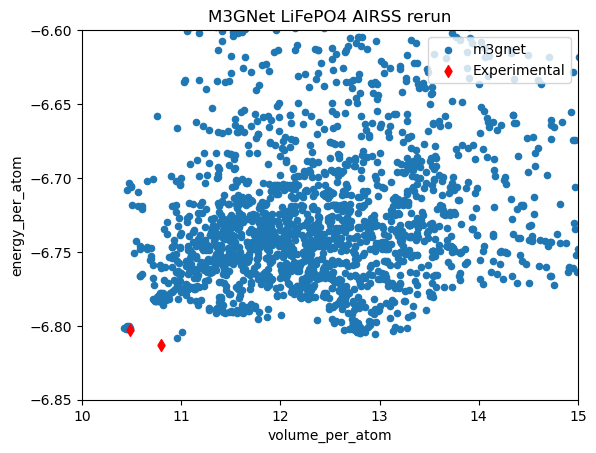

In [7]:
ax = df_m3g.plot.scatter('volume_per_atom', 'energy_per_atom', label='m3gnet')
ax.scatter( [lfp_relaxed_volume, lfp_cmcm_relaxed_volume], [lfp_relaxed_energy, lfp_cmcm_relaxed_energy],  marker='d', color='r', label='Experimental')
ax.set_xlim(10, 15)
ax.set_ylim(-6.85, -6.6)
ax.legend(loc=1)
ax.set_title('M3GNet LiFePO4 AIRSS rerun')

The top three structures in the DFT search are the $Pnma$ structure

In [8]:
df_dft.iloc[:3]

,atoms,label,energy,energy_per_atom,volume,volume_per_atom
209,"(Atom('Li', [-1.27204080371, -0.08562405684, -...",4LFP_actual-201127-012020-107264,-12150.5489,-433.948175,293.964179,10.498721
2185,"(Atom('Li', [1.2645500751, 2.8846016452910335,...",4LFP_actual-201126-142402-eb7dce,-12150.4655,-433.945196,291.994353,10.428370
2304,"(Atom('Li', [0.0, 2.98881, 0.0], index=0), Ato...",4LFP_actual-201126-144638-9aee88,-12150.3458,-433.940921,293.828259,10.493866


The top three structures in the M3GNet search The first structure are in fact very close to the $Pnma$ structure.
The second and the third structure has much larger volume, however which is potentially an false minima.

In [9]:
df_m3g.iloc[:3]

,atoms,label,energy,energy_per_atom,volume,volume_per_atom
2304,"(Atom('Li', [1.2980831344313938e-08, 3.0477790...",4LFP_actual-201126-144638-9aee88,-190.6370,-6.808464,306.752400,10.955443
896,"(Atom('Li', [1.4982718026222916, -2.7811777820...",4LFP_actual-201126-194829-b3779f,-190.5574,-6.805621,362.857838,12.959209
1347,"(Atom('Li', [-0.10981643308137104, 1.862519399...",4LFP-201124-120454-c024e6,-95.2657,-6.804693,179.228053,12.802004


In [10]:
#view([*df_m3g.iloc[:3].atoms, AseAtomsAdaptor.get_atoms(lfp_relaxed)])

Results from additional structure sampled with M3GNet.

Due to the low cost of M3GNet relaxation, we can afford sampling much more structures than DFT even if the latter already uses low-cost setting focusing on the speed.

This time the $Pnma$ structure is still not found.

Text(0.5, 1.0, 'M3GNet LiFePO4 extras')

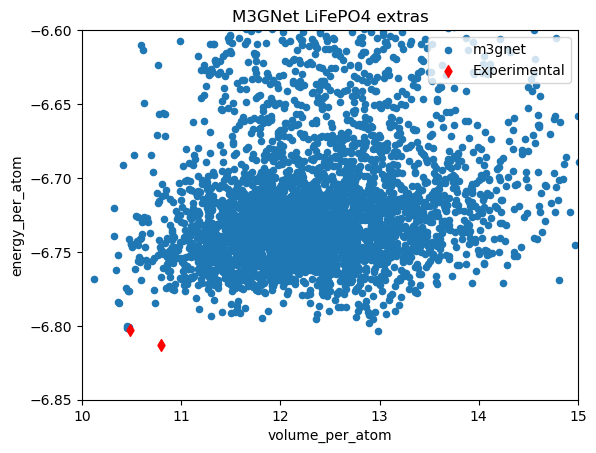

In [11]:
ax = df_m3g_extras.plot.scatter('volume_per_atom', 'energy_per_atom', label='m3gnet')
ax.scatter( [lfp_relaxed_volume, lfp_cmcm_relaxed_volume], [lfp_relaxed_energy, lfp_cmcm_relaxed_energy],  marker='d', color='r', label='Experimental')
ax.set_xlim(10, 15)
ax.set_ylim(-6.85, -6.6)
ax.legend(loc=1)
ax.set_title('M3GNet LiFePO4 extras')

The top structure has an increased volume this time.

In [12]:
df_m3g_extras.iloc[:4]

,atoms,label,energy,energy_per_atom,volume,volume_per_atom
1390,"(Atom('Li', [-1.1350046904651516, -2.454437522...",4LFP-extras-2879,-190.4938,-6.803350,363.653936,12.987641
2377,"(Atom('Li', [-1.5309058610971905e-07, -3.47717...",4LFP-extras-3721,-190.4353,-6.801261,292.665307,10.452332
2418,"(Atom('Li', [-0.9141561212472172, -1.608771912...",4LFP-extras-2798,-190.4301,-6.801075,293.326901,10.475961
186,"(Atom('Li', [-0.06135356788171718, 1.447172254...",4LFP-extras-2148,-190.4099,-6.800354,292.869739,10.459634


Results of the DFT PBE + U search using CASTEP with the QC5 pseudopotential.

Both the $Pnma$ and the $Cmcm$ phases have been found. 
The DFT energies have large spreads due to the coarse calculation settings used.

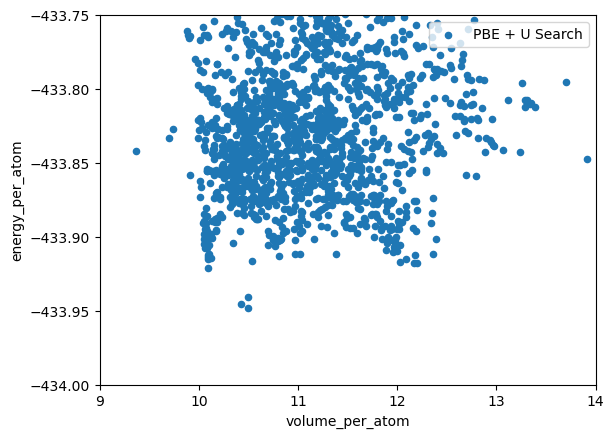

In [13]:
ax = df_dft.plot.scatter('volume_per_atom', 'energy_per_atom', xlim=(9, 14), ylim=(-434, -433.75), label='PBE + U Search')
ax.legend(loc=1)

Structure from the DFT calculations re-relaxed using VASP PBE + U.
The settings used the different from those in the Materials Project (used for M3GNet training) hence the energies are not comparable.

Nevertheless, the low energy $Pnma$ and $Cmcm$ phases can be seen.

(-6.9, -6.65)

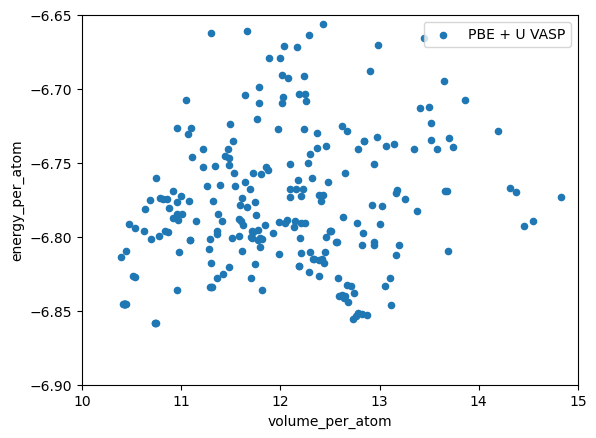

In [14]:
ax = df_dft_refine.plot.scatter('volume_per_atom', 'energy_per_atom', label='PBE + U VASP')
ax.legend(loc=1)
ax.set_xlim(10, 15)
ax.set_ylim(-6.90, -6.65)

In [15]:
#view([*df_dft.iloc[:3].atoms])

## Histogram comparison

Compare the distribution of the low energy structures. This gives some hint of distribution of the local minima in the potential energy surface.

Very different distributions means the potential energy surfaces are very different...

In [16]:
import matplotlib.pyplot as plt

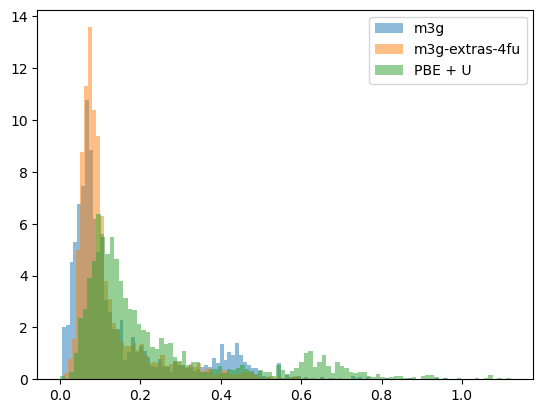

In [17]:
engs = df_m3g['energy_per_atom'].values.copy()
engs_m3g = engs - lfp_relaxed_energy
engs = df_m3g_extras['energy_per_atom'].values.copy()
engs_m3g_extras = engs - lfp_relaxed_energy

engs = df_dft['energy_per_atom'].values.copy()
engs_dft = engs - engs.min()

plt.hist(engs_m3g, bins=100,alpha=0.5,density=True, label='m3g');
plt.hist(engs_m3g_extras, range=(0,1), bins=100,alpha=0.5,density=True, label='m3g-extras-4fu');

plt.hist(engs_dft, bins=100, alpha=0.5, density=True, label='PBE + U')
plt.legend()

The distributions do not differ much, indicating the M3GNet has done a good job here!

# Conclusion

For $\ce{LiFePO4}$ M3GNet is capable of locating the low energy $Cmcm$ phase as well as the $Pnma$ phase, although there seems to be some complication with the latter, but it is very likely the true DFT ground state can be recovered after further DFT relaxation.

In addition, M3GNet has done a good job reproducing the DFT energy landscape in terms of the low energy basin distributions.

So can we use M3GNet for searching? I am not sure, there are other things one should note:

- M3GNet appears to generate false minima, which is unlikely to happen for DFT calculation despite the use of coarse settings.

- On the other hand, M3GNet has much reduced calculation costs hence much more structures may be sampled. The true ground state can still be recovered even if there are false minima. 

- One should note that M3GNet is built from a vast database of DFT calculation while a DFT search does not rely on any pre-existing data apart from some estimate specie-wise distances. 

- Another fine print - the Materials Project contains many data for oxide and phosphates, in addition it also has relative large set of data for $\ce{LiFePO4}$ polymorphs. The training data for M3GNet certainly includes the $Pnma$ and the $Cmcm$ structures.



Hence, further testing is need! Does M3GNet work well where the ground state is not included in the training set? What about cases where the stoichiometry is not in the trainin set at all? 